/home/syukrillah/Documents/sem_6/.env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/syukrillah/Documents/sem_6/.env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/syukrillah/Documents/sem_6/.env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/syukrillah/Documents/sem_6/.env/lib/python3.12/site-packages/statsmode

=== Model Evaluation Metrics ===
                         p  d  q       MAE      RMSE  MAPE (%)
Region                                                        
KABUPATEN BANDUNG        1  1  1  10070.45  11397.83       NaN
KABUPATEN BANDUNG BARAT  1  1  1   4472.66   5060.39       NaN
KABUPATEN BEKASI         1  1  1   6646.40   7519.22       NaN
KABUPATEN BOGOR          1  1  1  10817.16  12237.29       NaN
KABUPATEN CIAMIS         1  1  1   3980.34   4504.25       NaN
KABUPATEN CIANJUR        1  1  1   7200.39   8146.75       NaN
KABUPATEN CIREBON        1  1  1   7221.79   8172.56       NaN
KABUPATEN GARUT          1  1  1   7414.98   8390.87       NaN
KABUPATEN INDRAMAYU      1  1  1   5468.20   6187.40       NaN
KABUPATEN KARAWANG       1  1  1   6674.90   7553.98       NaN
KABUPATEN KUNINGAN       1  1  1   2693.76   3048.59       NaN
KABUPATEN MAJALENGKA     1  1  1   4495.45   5085.68       NaN
KABUPATEN PANGANDARAN    1  1  1   1709.27   1934.43       NaN
KABUPATEN PURWAKARTA  

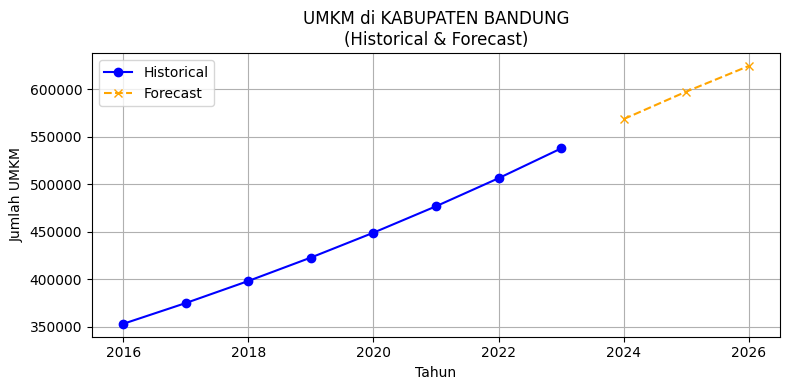

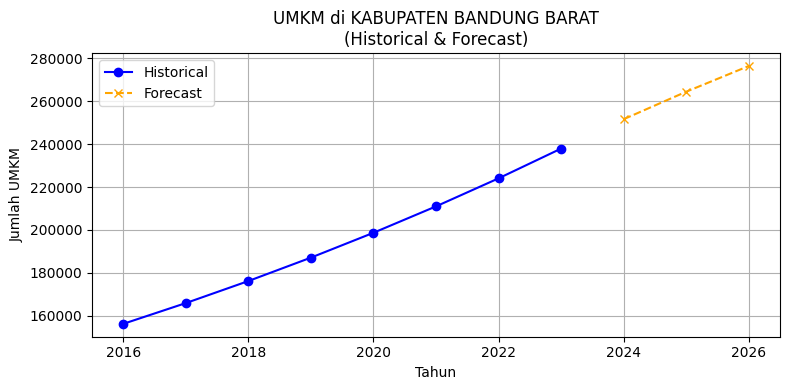

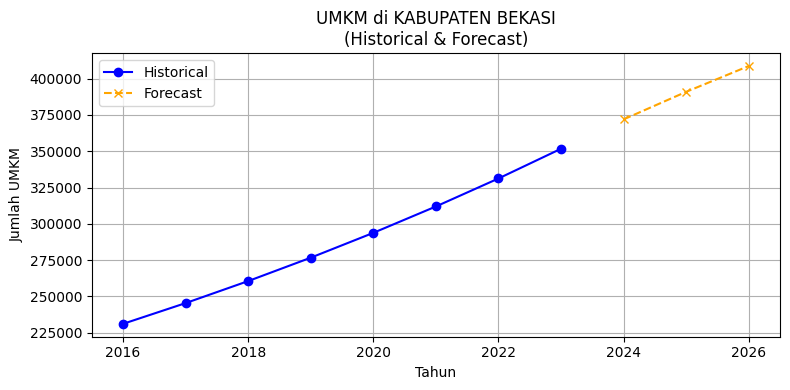

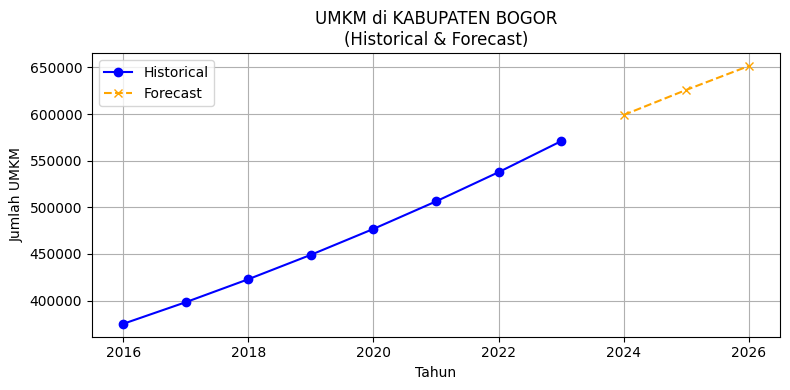

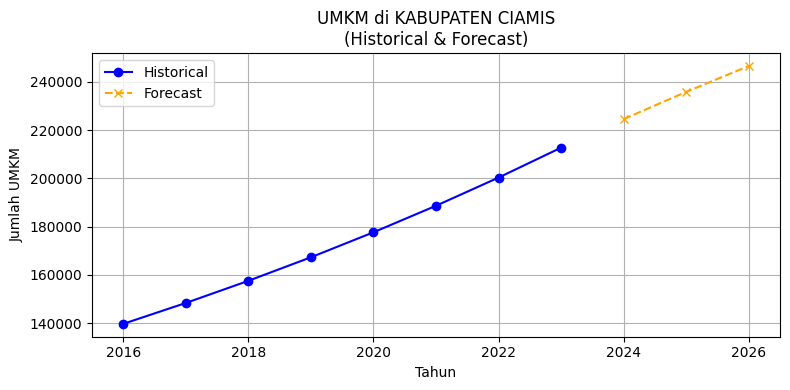

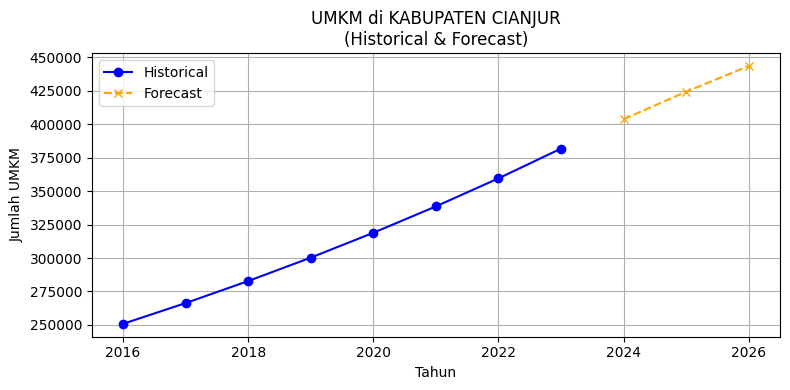

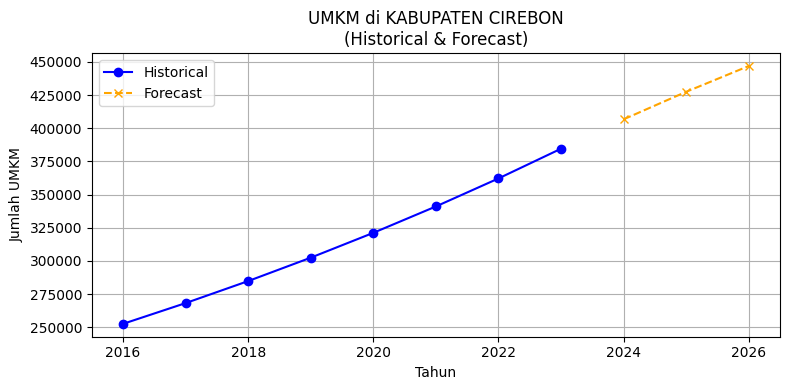

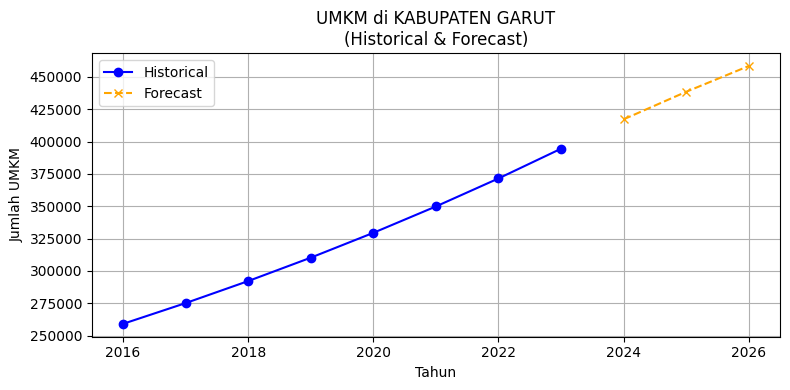

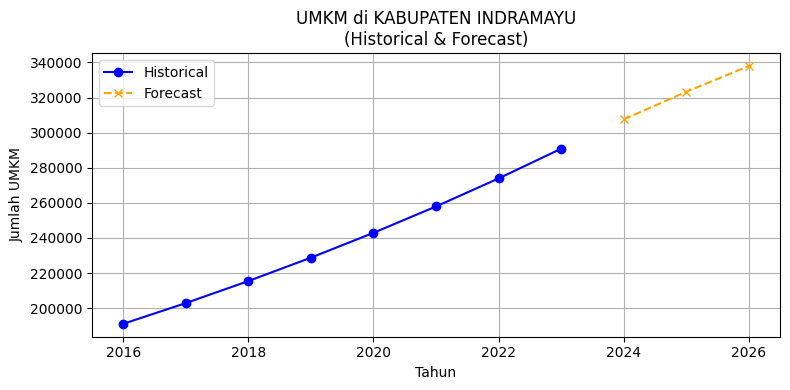

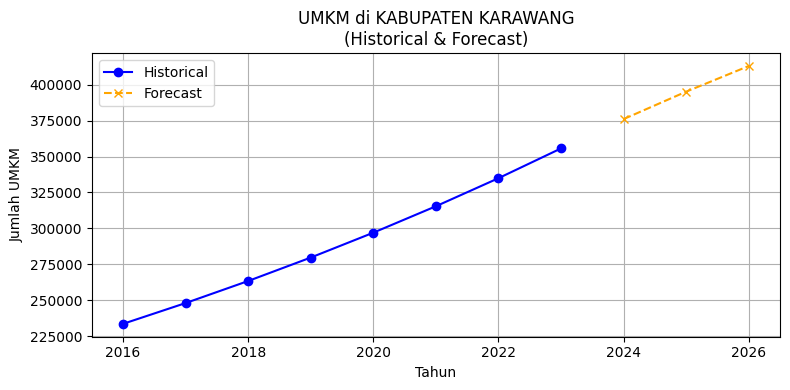

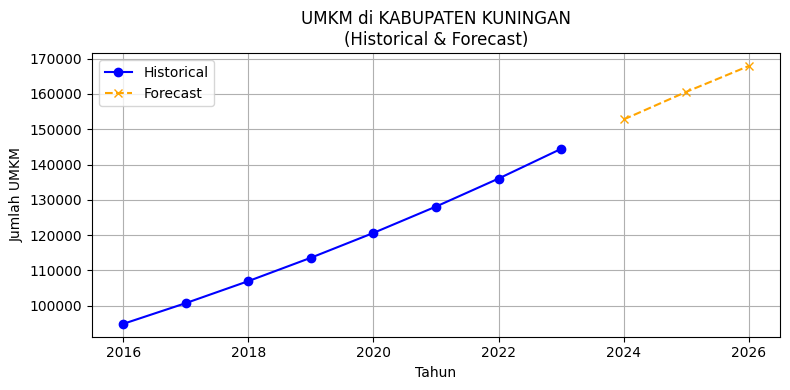

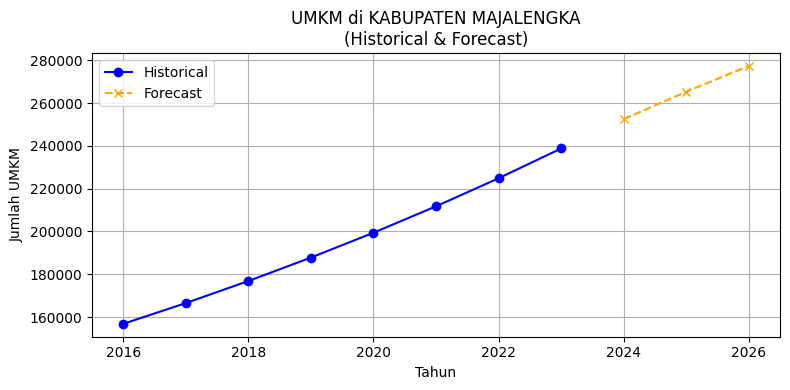

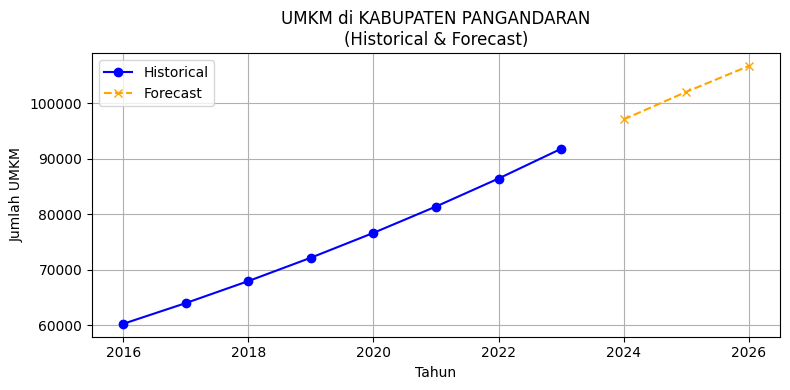

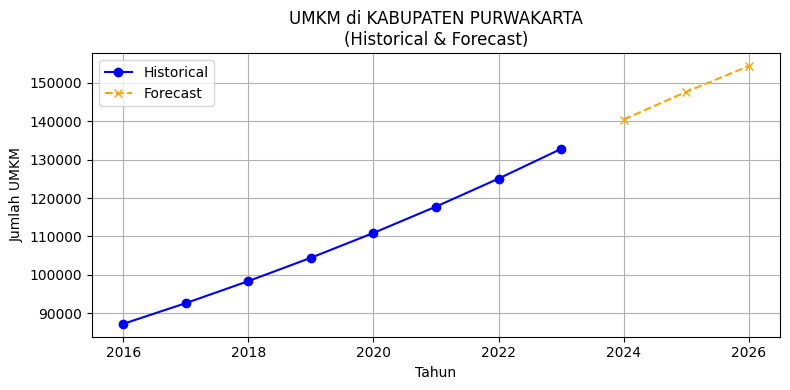

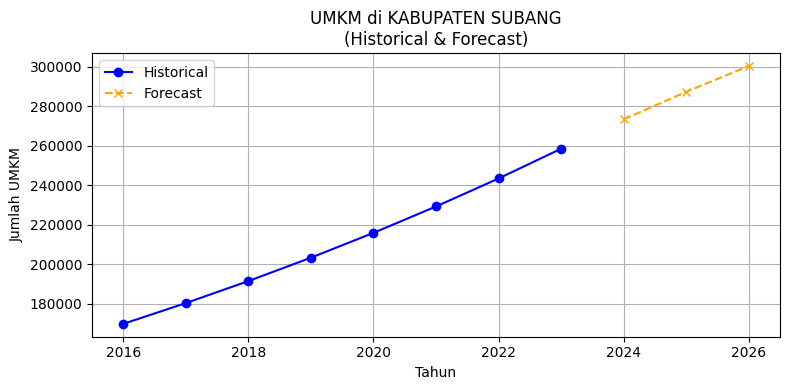

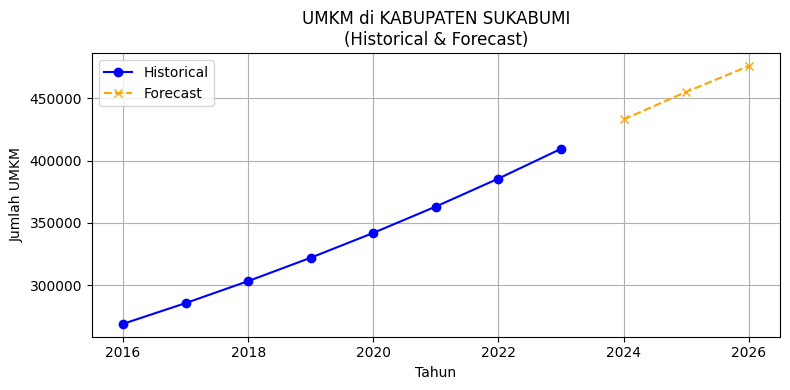

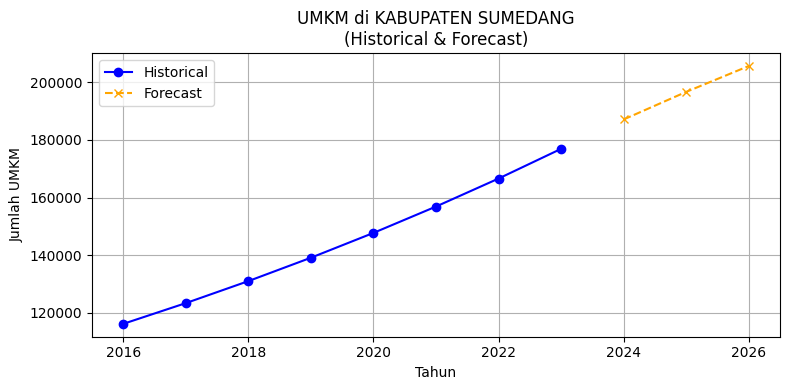

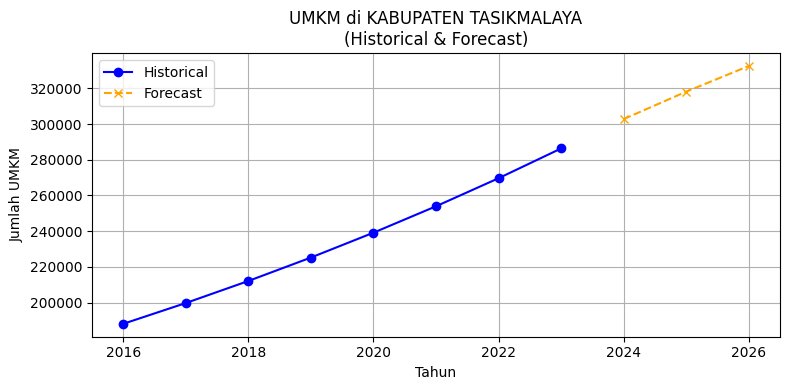

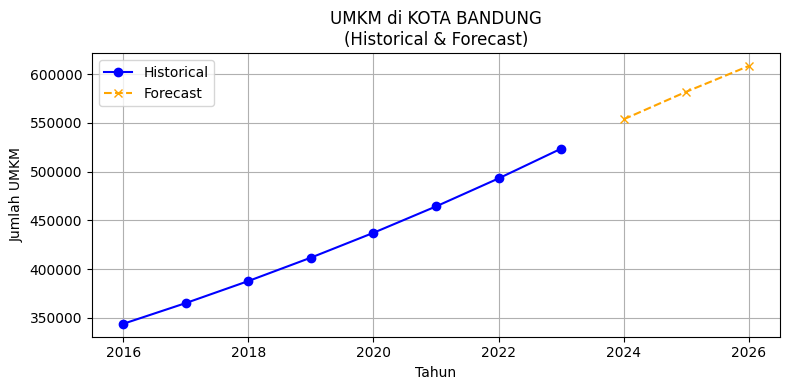

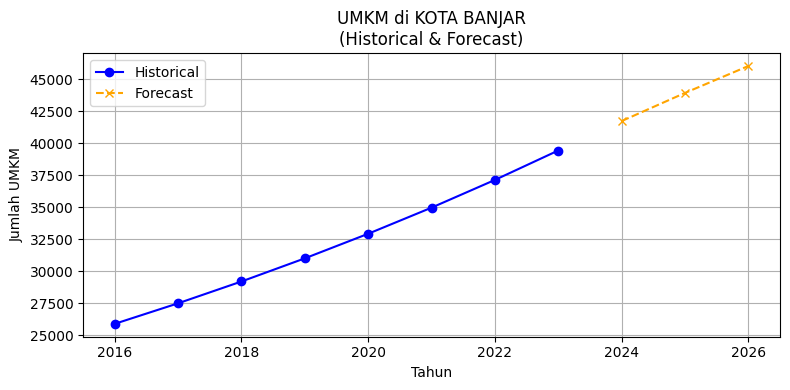

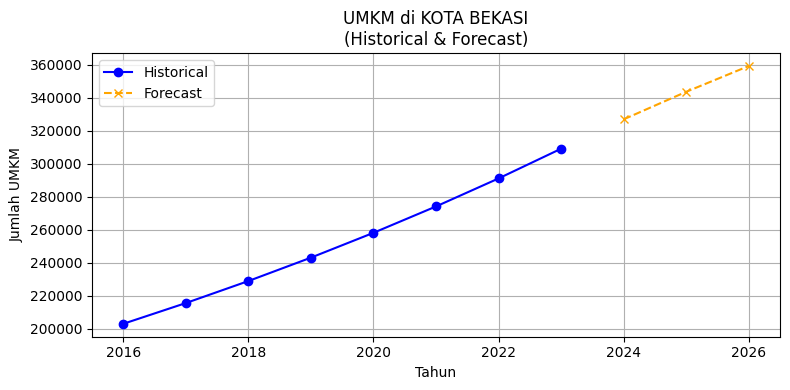

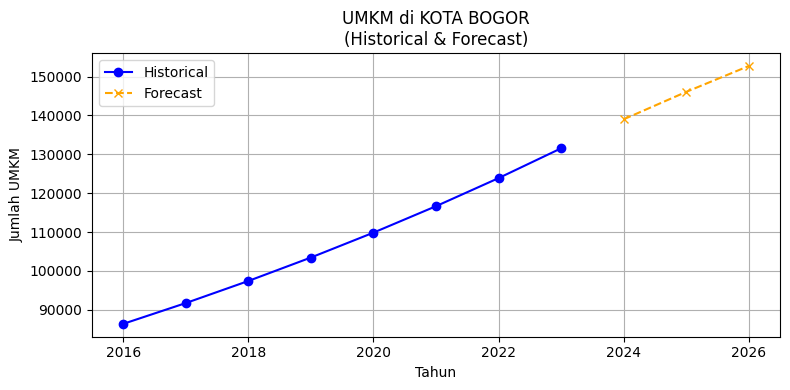

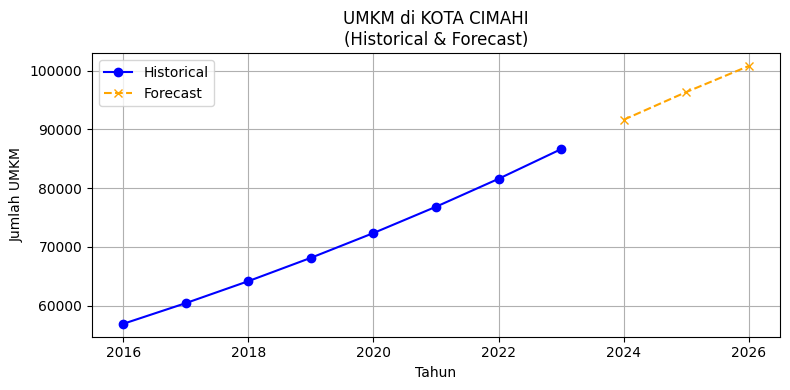

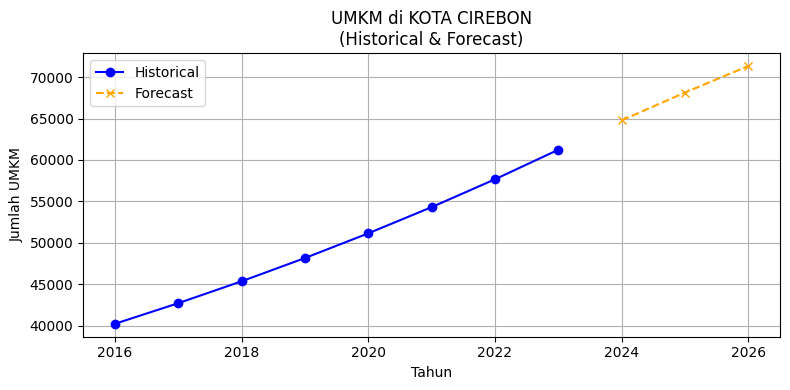

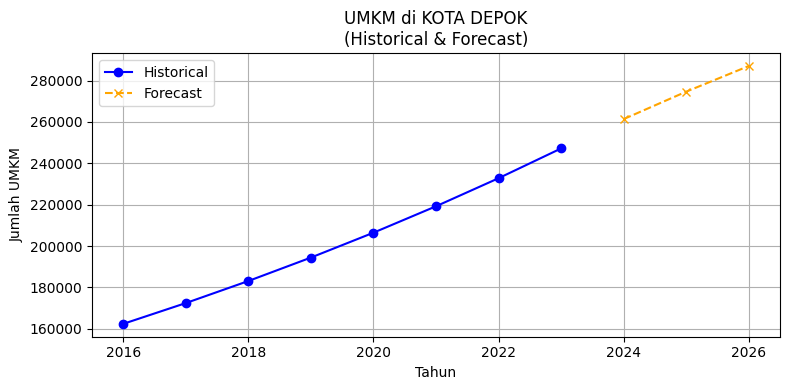

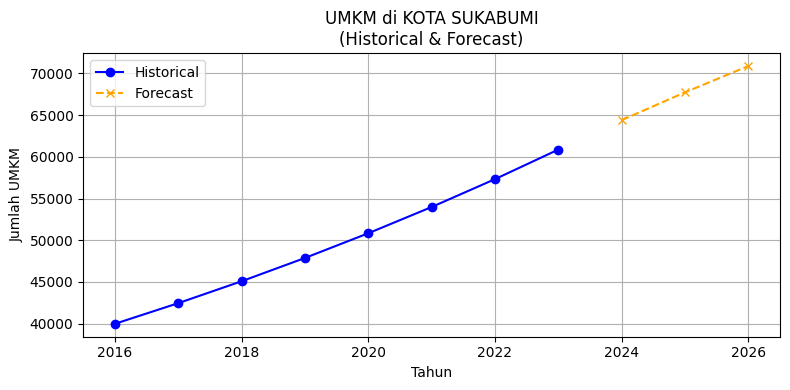

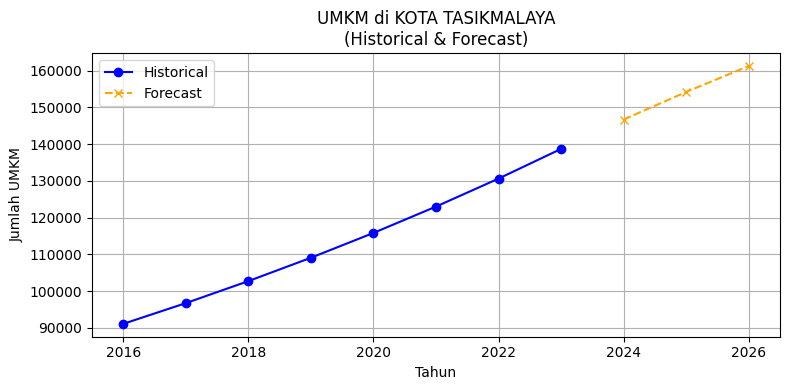

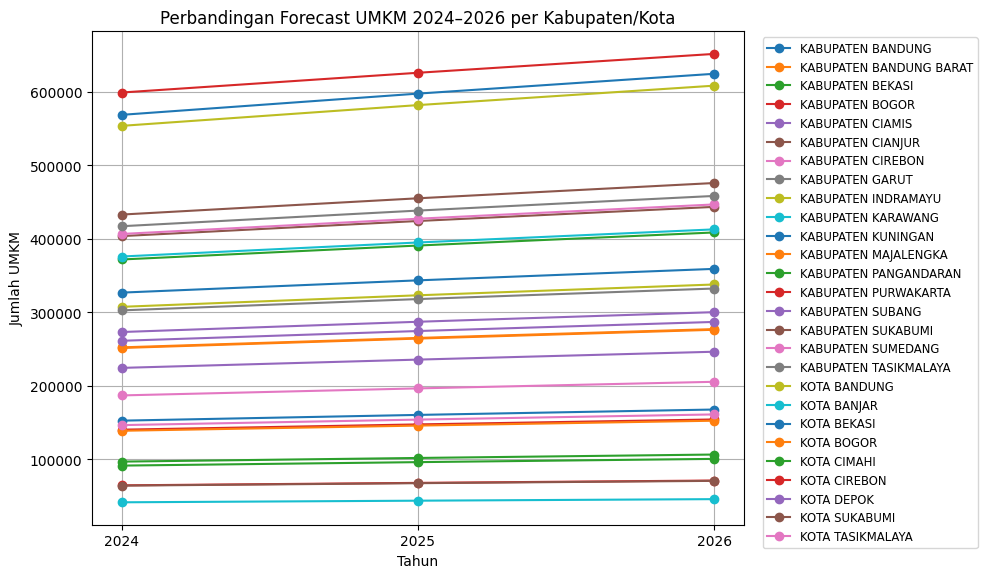

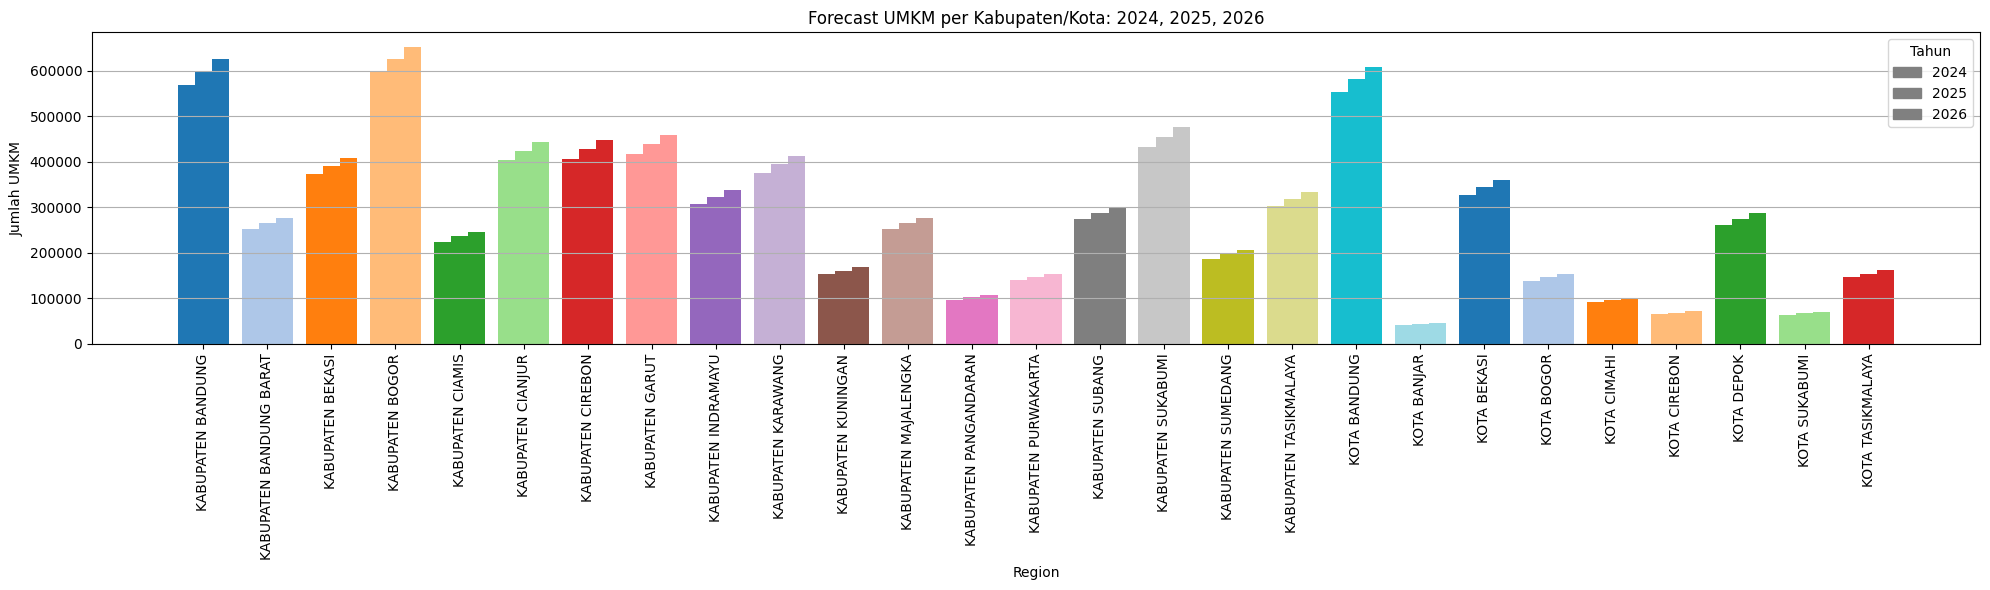

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.patches import Patch

# --- 1. Load & Pivot ---
file_path = "diskuk-od_17372_proyeksi_jml_ush_mikro_kecil_menengah_umkm__kabupa_v1_data.csv"
df = pd.read_csv(file_path)
df_pivot = df.pivot(index='tahun', 
                    columns='nama_kabupaten_kota', 
                    values='proyeksi_jumlah_umkm')
df_pivot.index = df_pivot.index.astype(int)

# --- 2. Train/Test & ARIMA + Forecast ---
train_years = list(range(2016, 2021))
test_years  = list(range(2021, 2024))

results = []
forecasts = {}

for region in df_pivot.columns:
    series = df_pivot[region].dropna()
    if series.shape[0] < len(train_years) + 1:
        continue

    # Stasioneritas
    pvalue = adfuller(series)[1]
    d = 0 if pvalue <= 0.05 else 1

    # Fit ARIMA(1,d,1)
    p, q = 1, 1
    model_full = ARIMA(series, order=(p, d, q)).fit()

    # Evaluasi out-of-sample
    train = series.loc[train_years]
    test  = series.loc[test_years]
    model_train = ARIMA(train, order=(p, d, q)).fit()
    forecast_test = model_train.forecast(steps=len(test))

    mae  = mean_absolute_error(test, forecast_test)
    rmse = np.sqrt(mean_squared_error(test, forecast_test))
    mape = np.mean(np.abs((test - forecast_test) / test)) * 100

    results.append({
        'Region': region,
        'p': p, 'd': d, 'q': q,
        'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape
    })

    # Forecast 2024–2026
    fc = model_full.forecast(steps=3)
    forecasts[region] = fc.values

# --- 3. Compile Results & Forecast DataFrames ---
results_df  = pd.DataFrame(results).set_index('Region').round(2)
forecast_df = pd.DataFrame(forecasts, index=[2024, 2025, 2026])

print("=== Model Evaluation Metrics ===")
print(results_df)
print("\n=== Forecast 2024–2026 ===")
print(forecast_df.round(0))

# --- 4. Plot per Region (Historical & Forecast) ---
forecast_df.index = forecast_df.index.astype(int)

for region in df_pivot.columns:
    if region not in forecast_df.columns:
        continue
    plt.figure(figsize=(8, 4))
    plt.plot(df_pivot.index, df_pivot[region], 
             marker='o', linestyle='-', color='blue', label='Historical')
    plt.plot(forecast_df.index, forecast_df[region], 
             marker='x', linestyle='--', color='orange', label='Forecast')
    plt.title(f'UMKM di {region}\n(Historical & Forecast)')
    plt.xlabel('Tahun')
    plt.ylabel('Jumlah UMKM')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- 5. Combined Forecast Line Plot ---
plt.figure(figsize=(10, 6))
for region in forecast_df.columns:
    plt.plot(forecast_df.index, forecast_df[region],
             marker='o', label=region)
plt.title('Perbandingan Forecast UMKM 2024–2026 per Kabupaten/Kota')
plt.xlabel('Tahun')
plt.ylabel('Jumlah UMKM')
plt.xticks(forecast_df.index)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

# --- 6. Grouped Bar Chart 2024–2026 per Region ---
regions = forecast_df.columns.tolist()
years   = forecast_df.index.astype(int).tolist()
n_reg   = len(regions)
bar_w   = 0.8 / len(years)
indices = np.arange(n_reg)
cmap    = plt.get_cmap('tab20')
colors  = [cmap(i % 20) for i in range(n_reg)]

plt.figure(figsize=(20, 6))
for j, region in enumerate(regions):
    vals = forecast_df[region].values
    offsets = np.linspace(-0.8/2 + bar_w/2, 0.8/2 - bar_w/2, len(years))
    for k, year in enumerate(years):
        plt.bar(indices[j] + offsets[k], vals[k], width=bar_w, color=colors[j])

plt.xticks(indices, regions, rotation=90)
plt.xlabel('Region')
plt.ylabel('Jumlah UMKM')
plt.title('Forecast UMKM per Kabupaten/Kota: 2024, 2025, 2026')

legend_handles = [Patch(color='gray', label=str(y)) for y in years]
plt.legend(legend_handles, [str(y) for y in years], title='Tahun')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


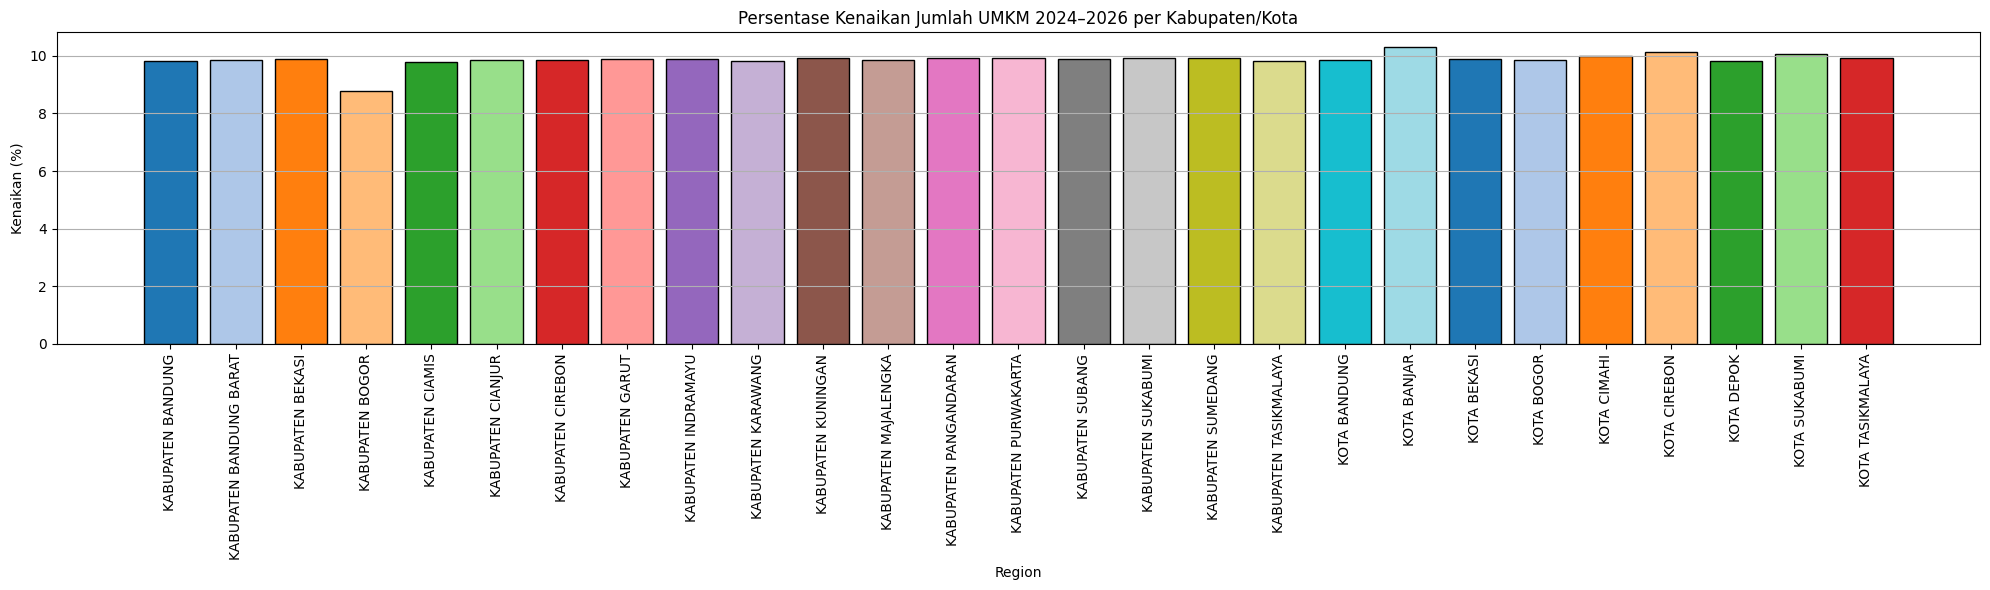

In [6]:
import matplotlib.pyplot as plt

# 7. Hitung persentase kenaikan total 2024–2026 per region
overall_pct = ((forecast_df.loc[2026] - forecast_df.loc[2024]) 
               / forecast_df.loc[2024]
              ).multiply(100).round(2)

# Siapkan warna unik per region
cmap = plt.get_cmap('tab20')
colors = [cmap(i % cmap.N) for i in range(len(overall_pct))]

# Plot bar chart dengan warna berbeda untuk tiap bar
plt.figure(figsize=(20, 6))
plt.bar(
    overall_pct.index,
    overall_pct.values,
    color=colors,
    edgecolor='black'
)

plt.title('Persentase Kenaikan Jumlah UMKM 2024–2026 per Kabupaten/Kota')
plt.xlabel('Region')
plt.ylabel('Kenaikan (%)')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
